### Матричные факторизации

В данной работе вам предстоит познакомиться с практической стороной матричных разложений.
Работа поделена на 4 задания:
1. Вам необходимо реализовать SVD разложения используя SGD на explicit данных
2. Вам необходимо реализовать матричное разложения используя ALS на implicit данных
3. Вам необходимо реализовать матричное разложения используя BPR на implicit данных
4. Вам необходимо реализовать матричное разложения используя WARP на implicit данных

Мягкий дедлайн 13 Октября (пишутся замечания, выставляется оценка, есть возможность исправить до жесткого дедлайна)

Жесткий дедлайн 20 Октября (Итоговая проверка)

In [1]:
import implicit
import pandas as pd
import numpy as np
import scipy.sparse as sp

from lightfm.datasets import fetch_movielens

В данной работе мы будем работать с explicit датасетом movieLens, в котором представленны пары user_id movie_id и rating выставленный пользователем фильму

Скачать датасет можно по ссылке https://grouplens.org/datasets/movielens/1m/

In [2]:
ratings = pd.read_csv('ml-1m/ratings.dat', delimiter='::', header=None, 
        names=['user_id', 'movie_id', 'rating', 'timestamp'], 
        usecols=['user_id', 'movie_id', 'rating'], engine='python')

In [3]:
movie_info = pd.read_csv('ml-1m/movies.dat', delimiter='::', header=None, 
        names=['movie_id', 'name', 'category'], engine='python', encoding="utf-8")

Explicit данные

In [4]:
ratings.head(10)

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
5,1,1197,3
6,1,1287,5
7,1,2804,5
8,1,594,4
9,1,919,4


Для того, чтобы преобразовать текущий датасет в Implicit, давайте считать что позитивная оценка это оценка >=4

In [5]:
implicit_ratings = ratings.loc[(ratings['rating'] >= 4)]

In [6]:
implicit_ratings.head(10)

,user_id,movie_id,rating
0,1,1193,5
3,1,3408,4
4,1,2355,5
6,1,1287,5
7,1,2804,5
8,1,594,4
9,1,919,4
10,1,595,5
11,1,938,4
12,1,2398,4


Удобнее работать с sparse матричками, давайте преобразуем DataFrame в CSR матрицы

In [7]:
users = implicit_ratings["user_id"]
movies = implicit_ratings["movie_id"]
user_item = sp.coo_matrix((np.ones_like(users), (users, movies)))
user_item_t_csr = user_item.T.tocsr()
user_item_csr = user_item.tocsr()

В качестве примера воспользуемся ALS разложением из библиотеки implicit

Зададим размерность латентного пространства равным 64, это же определяет размер user/item эмбедингов

In [8]:
model = implicit.als.AlternatingLeastSquares(factors=64, iterations=1, calculate_training_loss=True)

В качестве loss здесь всеми любимый RMSE

In [9]:
model.fit(user_item_t_csr)

100%|██████████| 1/1 [00:00<00:00,  2.62it/s, loss=0.0167]


Построим похожие фильмы по 1 movie_id = Истории игрушек

In [10]:
movie_info.head(5)

,movie_id,name,category
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
get_similars = lambda item_id, model : [movie_info[movie_info["movie_id"] == x[0]]["name"].to_string() for x in model.similar_items(item_id)]

In [12]:
model.similar_items(1)

[(1, 0.99999994),
 (588, 0.7420182),
 (3114, 0.7378711),
 (2355, 0.6996394),
 (1566, 0.6428456),
 (364, 0.6293163),
 (2081, 0.6259602),
 (595, 0.6095878),
 (2078, 0.5848971),
 (48, 0.58454555)]

Как мы видим, симилары действительно оказались симиларами.

Качество симиларов часто является хорошим способом проверить качество алгоритмов.

P.S. Если хочется поглубже разобраться в том как разные алгоритмы формируют разные латентные пространства, рекомендую загружать полученные вектора в tensorBoard и смотреть на сформированное пространство

In [13]:
get_similars(1, model)

['0    Toy Story (1995)',
 '584    Aladdin (1992)',
 '3046    Toy Story 2 (1999)',
 "2287    Bug's Life, A (1998)",
 '1526    Hercules (1997)',
 '360    Lion King, The (1994)',
 '2013    Little Mermaid, The (1989)',
 '591    Beauty and the Beast (1991)',
 '2010    Jungle Book, The (1967)',
 '47    Pocahontas (1995)']

Давайте теперь построим рекомендации для юзеров

Как мы видим юзеру нравится фантастика, значит и в рекомендациях ожидаем увидеть фантастику

In [14]:
get_user_history = lambda user_id, implicit_ratings : [movie_info[movie_info["movie_id"] == x]["name"].to_string() for x in implicit_ratings[implicit_ratings["user_id"] == user_id]["movie_id"]]

In [15]:
get_user_history(4, implicit_ratings)

['3400    Hustler, The (1961)',
 '2883    Fistful of Dollars, A (1964)',
 '1196    Alien (1979)',
 '1023    Die Hard (1988)',
 '257    Star Wars: Episode IV - A New Hope (1977)',
 '1960    Saving Private Ryan (1998)',
 '476    Jurassic Park (1993)',
 '1180    Raiders of the Lost Ark (1981)',
 '1886    Rocky (1976)',
 '1081    E.T. the Extra-Terrestrial (1982)',
 '3350    Thelma & Louise (1991)',
 '3634    Mad Max (1979)',
 '2298    King Kong (1933)',
 '1366    Jaws (1975)',
 '1183    Good, The Bad and The Ugly, The (1966)',
 '2624    Run Lola Run (Lola rennt) (1998)',
 '2879    Goldfinger (1964)',
 '1220    Terminator, The (1984)']

Получилось! 

Мы действительно порекомендовали пользователю фантастику и боевики, более того встречаются продолжения тех фильмов, которые он высоко оценил

In [16]:
get_recommendations = lambda user_id, model : [movie_info[movie_info["movie_id"] == x[0]]["name"].to_string() 
                                               for x in model.recommend(user_id, user_item_csr)]

In [17]:
get_recommendations(4, model)

['847    Godfather, The (1972)',
 '585    Terminator 2: Judgment Day (1991)',
 '1203    Godfather: Part II, The (1974)',
 '1932    Lethal Weapon (1987)',
 '1073    Reservoir Dogs (1992)',
 '453    Fugitive, The (1993)',
 '109    Taxi Driver (1976)',
 '1182    Aliens (1986)',
 '1569    Hunt for Red October, The (1990)',
 '1284    Butch Cassidy and the Sundance Kid (1969)']

Теперь ваша очередь реализовать самые популярные алгоритмы матричных разложений

Что будет оцениваться:
1. Корректность алгоритма
2. Качество получившихся симиларов
3. Качество итоговых рекомендаций для юзера

In [18]:
from factorization import SVD, SVDS
from datetime import datetime

In [19]:
get_similars = lambda item_id, model : movie_info[movie_info["movie_id"].isin(model.similar_items(item_id))][["name", "category"]]

get_recommendations = lambda user_id, model : movie_info[movie_info["movie_id"].isin(model.recommend(user_id))][["name", "category"]]

get_user_history = lambda user_id, implicit_ratings : movie_info[movie_info["movie_id"].isin(implicit_ratings[implicit_ratings["user_id"] == user_id]["movie_id"])][["name", "category"]]

In [20]:
def test(model):
    item_id = 1
    target = movie_info[movie_info.movie_id == item_id]
    print(f"Similar to {target.name.item()} ({target.category.item()}):")
    sims = model.similar_items(item_id)
    
    for idx, i in enumerate(sims):
        selected = movie_info[movie_info.movie_id == i]
        print(f"{idx + 1}) {selected.name.item()} ({selected.category.item()})")
    
    print()
    
    user_id = 4
    print(f"Recommended movies for user {user_id}:")
    recs = model.recommend(user_id)
    
    for idx, i in enumerate(recs):
        selected = movie_info[movie_info.movie_id == i]
        print(f"{idx + 1}) {selected.name.item()} ({selected.category.item()})")

### Задание 1. Не использую готовые решения, реализовать SVD разложение используя SGD на explicit данных

In [21]:
user_item_exp = sp.coo_matrix((ratings["rating"], (ratings["user_id"], ratings["movie_id"])))

In [22]:
# %%time
# model_svd = SVD(64, iterations    =1000, lr=1e-4, verbose=True, weight_decay=1e-2)
# model_svd.fit(user_item_exp)  

# timestamp = datetime.now()
# model_svd.logger.save(f"log.{timestamp.date()}_{timestamp.time()}.csv")
# model_svd.logger.plot("iter", "rmse", label="RMSE", x_label="Iteration", y_label="RMSE")

In [23]:
# test(model_svd)

In [24]:
# %%time
# model_svds = SVDS(64, iterations=50, lr=1e-2, verbose=True, weight_decay=1e-2, save_every=10)

# model_svds.fit(user_item_exp)

# timestamp = datetime.now()
# model_svds.logger.save(f"log.{timestamp.date()}_{timestamp.time()}.csv")
# model_svds.logger.plot("iter", "rmse", label="RMSE", x_label="Iteration", y_label="RMSE")

In [25]:
# test(model_svds)

### Задание 2. Не использую готовые решения, реализовать матричное разложение используя ALS на implicit данных

In [26]:
# from factorization import ALS

In [27]:
# model_als = ALS(64, 10, 1e-5, 1e-5, True)

# model_als.fit(user_item_csr)

# timestamp = datetime.now()
# model_als.logger.save(f"log.{timestamp.date()}_{timestamp.time()}.csv")
# model_als.logger.plot("iter", "rmse", label="RMSE", x_label="Iteration", y_label="RMSE")

In [28]:
# test(model_als)

### Задание 3. Не использую готовые решения, реализовать матричное разложение BPR на implicit данных

In [29]:
from factorization import BPR

### Задание 4. Не использую готовые решения, реализовать матричное разложение WARP на implicit данных

Iter:   1000 | AUC: 0.61446
Iter:   2000 | AUC: 0.68798
Iter:   3000 | AUC: 0.73297
Iter:   4000 | AUC: 0.76403
Iter:   5000 | AUC: 0.78673
Iter:   6000 | AUC: 0.80374
Iter:   7000 | AUC: 0.81685
Iter:   8000 | AUC: 0.82700
Iter:   9000 | AUC: 0.83504
Iter:  10000 | AUC: 0.84145
Iter:  11000 | AUC: 0.84676
Iter:  12000 | AUC: 0.85113
Iter:  13000 | AUC: 0.85489
Iter:  14000 | AUC: 0.85818
Iter:  15000 | AUC: 0.86093
Iter:  16000 | AUC: 0.86332
Iter:  17000 | AUC: 0.86543
Iter:  18000 | AUC: 0.86732
Iter:  19000 | AUC: 0.86897
Iter:  20000 | AUC: 0.87052
Iter:  21000 | AUC: 0.87187
Iter:  22000 | AUC: 0.87314
Iter:  23000 | AUC: 0.87431
Iter:  24000 | AUC: 0.87536
Iter:  25000 | AUC: 0.87636
Iter:  26000 | AUC: 0.87724
Iter:  27000 | AUC: 0.87805
Iter:  28000 | AUC: 0.87882
Iter:  29000 | AUC: 0.87957
Iter:  30000 | AUC: 0.88020
Iter:  31000 | AUC: 0.88081
Iter:  32000 | AUC: 0.88139
Iter:  33000 | AUC: 0.88197
Iter:  34000 | AUC: 0.88251
Iter:  35000 | AUC: 0.88301
Iter:  36000 | AUC: 

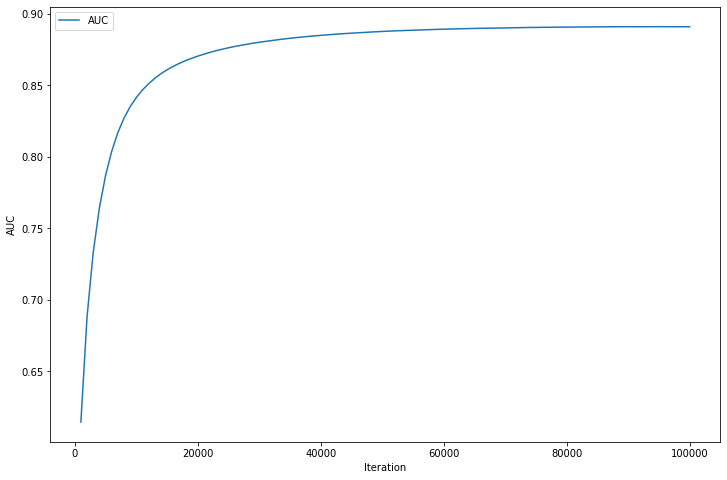

In [30]:
model_bpr = BPR(64, int(1e5), 1e-3, 1e-5, True)

model_bpr.fit(user_item_csr, batch_size=64)

timestamp = datetime.now()
model_bpr.logger.save(f"log.{timestamp.date()}_{timestamp.time()}.csv")
model_bpr.logger.plot("iter", "AUC", label="AUC", x_label="Iteration", y_label="AUC")

In [31]:
test(model_bpr)

Similar to Toy Story (1995) (Animation|Children's|Comedy):
1) Toy Story (1995) (Animation|Children's|Comedy)
2) Star Wars: Episode IV - A New Hope (1977) (Action|Adventure|Fantasy|Sci-Fi)
3) Star Wars: Episode VI - Return of the Jedi (1983) (Action|Adventure|Romance|Sci-Fi|War)
4) Shakespeare in Love (1998) (Comedy|Romance)
5) Princess Bride, The (1987) (Action|Adventure|Comedy|Romance)
6) Star Wars: Episode V - The Empire Strikes Back (1980) (Action|Adventure|Drama|Sci-Fi|War)
7) American Beauty (1999) (Comedy|Drama)
8) Saving Private Ryan (1998) (Action|Drama|War)
9) Being John Malkovich (1999) (Comedy)
10) Sixth Sense, The (1999) (Thriller)

Recommended movies for user 4:
1) American Beauty (1999) (Comedy|Drama)
2) Star Wars: Episode V - The Empire Strikes Back (1980) (Action|Adventure|Drama|Sci-Fi|War)
3) Sixth Sense, The (1999) (Thriller)
4) Silence of the Lambs, The (1991) (Drama|Thriller)
5) Star Wars: Episode VI - Return of the Jedi (1983) (Action|Adventure|Romance|Sci-Fi|War)
